<div style="text-align: left">
<a href="http://www.datascience-paris-saclay.fr"><img src="http://project.inria.fr/saclaycds/files/2017/02/logoUPSayPlusCDS_990.png" width="70%"></a>
</div>

# [RAMP](https://www.ramp.studio/problems/) on Melanomas detection and prevention

Authors : 
_Jean Babin, Victorien Gimenez , Vincent Jacob, Cyril Equilbec_

1. [Introduction](#Introduction)
    1. The predictive task
    2. Quantitative score and prediction value (quantitave scores)
    3. Expected usage of the predictor
2. [Data](#Data)
3. [Workflow](#Workflow)
4. [Evaluation](#Scoring)
5. [Baseline Model](#Baseline-Model)
6. [Local testing](#Local-testing)
7. [Submission](#Submitting-to-ramp.studio)
8. [More information](#More-information)

# Introduction

Skin diseases are very common, especially melanoma and require full attention. Indeed, the statistics are striking : Melanoma skin cancer is the 5th most common cancer in the UK, accounting for 4% of all new cancer cases (2015). 
1 person dies of melanoma every hour in North America, 1 out of 5 people in the USA will eventually contract a skin cancer during their lifetime and an interesting fact motivating our challenge : 70% of skin cancers are first detected by the patients themselves or their relatives.

Skin cancer is a major problem but unfortunately underestimated : too few people regularly consult a dermatologist, which can be understood because getting an appointment can be really long.

However, several initiatives have been launched to simplify the prevention of this disease, including the [Molescope](https://molescope.com/) smartphone application that allows the user to take a picture of your mole with a special physical device and share it with a dermatologist. This is a great initiative but it can be restrictive as you have to buy an extra device and wait for the dermatologist to send its feedback. 

This is why we propose to use data science to build a strong classifier able to distinguish between benign moles, moles suspicious enough to require a profesionnal point of view for further examinations and already dangerous moles which require immediate attention.
This classifier should be used as a part of a fully automated smartphone application which basically will allow the user to take a snapshot of one of his mole and get instant feedback.

A good prediction could lead to a significant improvement in the prevention of melanoma.


### The prediction task

This challenge proposes to design the best algorithm to detect suspicious and potentially dangerous beauty spots from an extensive database mostly created from the [Isic archive](https://www.isic-archive.com/?fbclid=IwAR1z5lIE-A_zGL1ewbxjQG6Q7AfRq4mgIsRO_afgb6jVFpVK2f0ittcHHWI#!/onlyHeaderTop/gallery) and the [Addi project](http://www.fc.up.pt/addi/project.html)  containing a thousand 1022 ☓ 767 pixels verified and colored pictures of moles representing different stages of the disease or innocuous moles.

After sorting and selecting the most relevant samples, we give to the users a subset of this large dataset in order to test and calibrate their algorithms. 

<img src="./img/mole.png" width="500" />
<div style="text-align: center; font-style: italic">Example of a mole given in the dataset</div>

<br />
We provide a dataset already rescaled to 400 ☓ 400 pixels images and into grayscale by averaging the RGB channels and rescaling the picture using scikit learn library. 

<img src="./img/outfile.jpg" width="500" />
<div style="text-align: center; font-style: italic">Rescaled picture of a mole</div><br />

Using an appropriate metric, we will compare the true solution to the estimation. The goal is to provide detection of more than 90% moles suspicious enough to require further examinations by a dermatologist with a minimum number of false negative. If the objective is met, the next step would be to enhance the data base with amateur photos to improve the reliability of the classifier in real situations, unfortunately, those photos are difficult to gather. 

With no further do, let's have a look at the data.

### Required dependencies and downloads

#### Installation of libraries and `ramp-workflow`

To get this notebook running and test your models locally using the `ramp_test_submission`, we recommend that you use the Python distribution from [Anaconda](https://www.anaconda.com/download/) or [Miniconda](https://conda.io/miniconda.html). 

Uncomment the following line to install required packages.

In [2]:
# !pip install -r requirements.txt

#### Download script (optional)

If the data has not yet been downloaded locally, uncomment the following cell and run it.

There are ~700Mb of images.

In [7]:
#!pip install googledrivedownloader
!python download_data.py

Starting downloading test data set...
=> File saved as data\data_test.zip
Starting downloading train data set...
=> File saved as data\data_test.zip


# Data

In [1]:
from __future__ import division, print_function

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
X_train =  np.load("data/data_train.npy")
X_test =  np.load("data/data_test.npy")

print("The training data is made of {} images of {} x {} pixels".format(
    *X_train.shape))

print("The test data is made of {} images of {} x {} pixels".format(
    *X_test.shape))

n_img = len(X_train)

The training data is made of 619 images of 400 x 400 pixels
The test data is made of 120 images of 400 x 400 pixels


Here we display 3 randomly select images. You can play around with the values.

In [17]:
idx_list = [30, 400, 519]

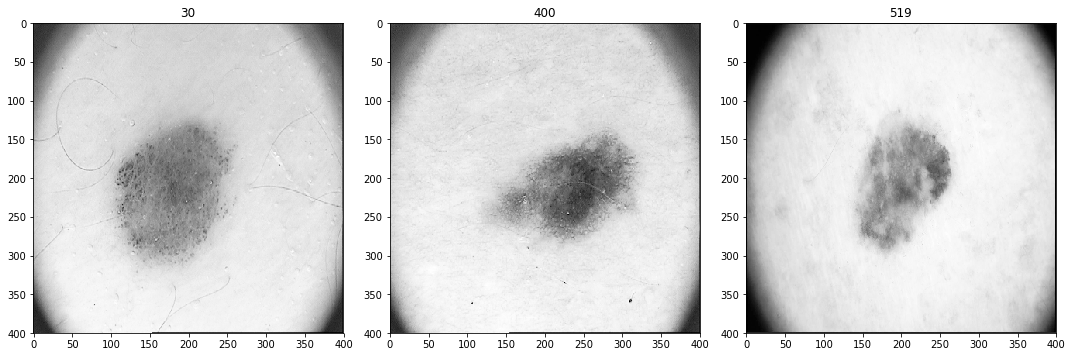

In [18]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for i, idx in enumerate(idx_list):
    axes[i].imshow(X_train[idx], cmap='Greys_r')
    axes[i].set_title('%d' % idx)
fig.tight_layout()

In [19]:
df = pd.read_csv("data/data_train_labels.csv")
ff = pd.read_csv("data/data_test_labels.csv")
y_train = np.array(df["label"])
y_test = np.array(ff["label"])

# Exploratory data analysis

### Label distribution

,label,id
Benign,0,324
Malignant,1,295


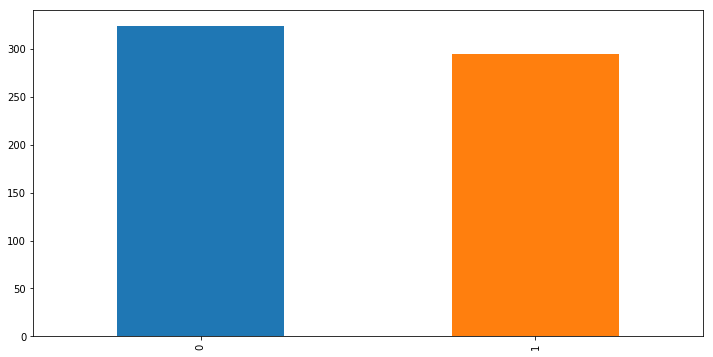

In [25]:
df['label'].value_counts().sort_index().plot.bar(figsize=(12, 6))
labels_name = ['Benign','Malignant']
labels_count_df = df.groupby(['label']).agg('count').reset_index()
labels_count_df = labels_count_df.set_index(pd.Index(labels_name))
labels_count_df


The labels consist of a `pandas.DataFrame` containing the list of images. For each images, the columns are
- `id`: index of the image it belongs to
- `label` : if it's benign (0) or not (1)

### Exploratory image analysis

#### Nevus size

One characteristic of a melanoma is its size. Usually big moles are malignant. Let us compare two of them as an example. Here, we count the number of dark pixels in each case.

In [26]:
threshold = 160

In [27]:
from scipy import ndimage

def count_dark_pixels(img):

    blobs = img < threshold
    labels = ndimage.label(blobs)[0]

    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 5))
    ax[0].imshow(img, cmap='Greys_r')
    ax[1].imshow(np.ma.masked_array(labels, ~blobs), cmap=plt.cm.rainbow)

    fig.tight_layout()
    plt.show()
    
    return blobs

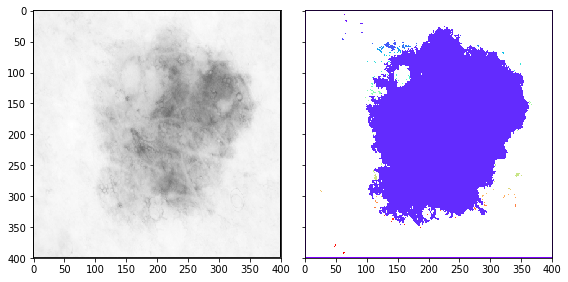

Number of dark pixels (Melanoma): 57840


In [28]:
print('Number of dark pixels (Melanoma):', np.sum(count_dark_pixels(X_train[515])))

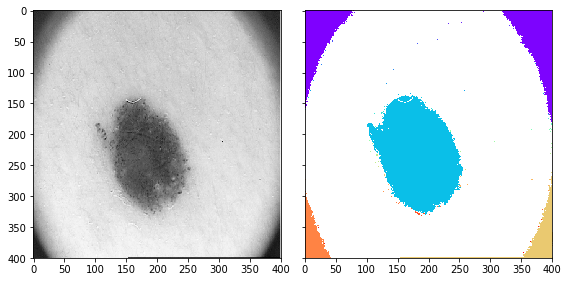

Number of dark pixels (Nevus): 34513


In [29]:
print('Number of dark pixels (Nevus):', np.sum(count_dark_pixels(X_train[10])))

Now we can compare sizes distribution for benign and malignant nevus over the whole dataset.

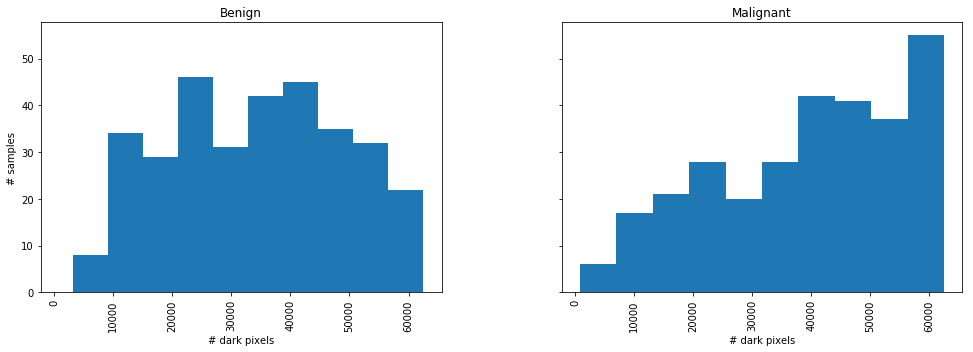

In [35]:
blobs_array = np.zeros((X_train.shape[0]))
# as the border of the picture is sometimes dark
# we plot the distribution of dark pixels only for a croped image
for i,x in enumerate(X_train):
    w, h = x.shape
    startx = h // 2-(250 // 2)
    starty = w // 2-(250 // 2)
    x = x[starty:starty + 250, startx:startx + 250]
    blobs_array[i] = np.sum(x < threshold)

df['cnt_dark_pixel'] = pd.Series(blobs_array)

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16, 5))
df.hist(column='cnt_dark_pixel', by='label', ax=axes)
axes[0].set_title(labels_name[0])
axes[0].set_xlabel('# dark pixels')
axes[0].set_ylabel('# samples')
axes[1].set_title(labels_name[1])
axes[1].set_xlabel('# dark pixels')
plt.show()

#### Borders

One of the main difference between a benign nevus and a melanoma is their shape. A melanoma usually has irregular borders with edges and corners. In image analysis, this is what we call image compactness. Here, we visually compare shape compactness between a benign nevus and a malignant one, taking two new observations.

In [38]:
from skimage import measure

def draw_contours(img, i):
    contours = measure.find_contours(img, 170, positive_orientation='high')
    contour = max(contours, key=len)
    
    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
    ax.set_title(labels_name[i])
    plt.show()

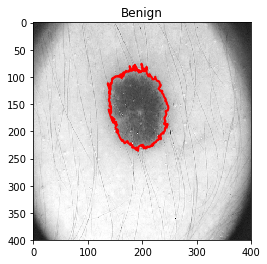

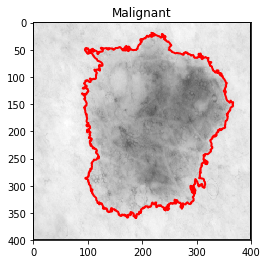

In [39]:
draw_contours(X_train[11], 0)
draw_contours(X_train[515], 1)

# Workflow

<img src="./img/workflow.png" />


This example of Workflow allows to build a full machine learning pipeline to recognize abnormal images of moles. If the model is well trained and robust enough, wich roughly means that the percentage of false-negative is low enough and the accuracy is satisfactory, then the model doesn't need further training and can remain still. In the case of a newly type of melanoma or mole disease discovery, then the algorithm needs to be retrained to include this new type. Ideally, since the classifier should be included in a smartphone application, the database should be regularly enriched with newly amateur photos to reflect as much as possible real life situations.

# Scoring

## Prediction value measurement and quantitative score(s)

### Usual classification metrics and their limitations

As a Machine Learning problem, the aim of this project is to provide a binary probabilistic classifier, that takes as an input a dermoscopic image of a mole, and provides as an output the probability of this mole being *malignant*, i.e. potentially dangerous for the patient. We will thus define the image to be classified as belonging to the **positive class** if it is malignant, and to the **negative class** if it is *benign*, i.e. not harmful.

We introduce the standard terminology used for such classification problems:

* **TP** = number of samples that were predicted as belonging to the positive class that are indeed positive (malignant moles here)
* **FP** = number of samples that were predicted positive but that are in fact negative
* **TN** = number of samples that were predicted as belonging to the negative class that are indeed negative (benign moles here)
* **FN** = number of samples that were predicted negative but that are in fact positive

For further readability, we also introduce some other terminology that is sometimes used:

* **P** = number of samples that are *really* labelled as belonging to the positive class, according to the gold standard malignancy diagnosis
* **N** = number of samples that are *really* labelled as negative

With all of this set up, we can define the metrics that are usually used for evaluating binary classifiers:

The most obvious and famous one is the **Accuracy**, which is simply the percentage of correctly classified samples among the data set, and read:

$$
AC = \frac{TP + TN}{P + N}
$$

Another very common classification metric is the **Recall**, also known as the **Sensitivity** in Statistics, or as the **True-Positive rate** TPR. This ratio expresses how much of the members of the positive class has been well predicted by the classifier:

$$
SE = \frac{TP}{TP + FN}
$$

One final common perfomance indicator that we will introduce is the **Specificity** (the complementary of what we will further call the False-Positive rate FPR), which this time describes how well the classifier did in identifying the members of the negative class:

$$
SP = \frac{TN}{TN + FP}
$$

Intuitively, these scores tend to describe well what we want to accomplish here: identify the right class for a given input. However, in our particular setting, like for most disease detection ones in Machine Learning, limiting us to a balanced combination of just these 3 scores will not be sufficient, nor reflect the true quality of the classifier's predictions.

First, our **dataset is quite imbalanced**: malignant moles only represent around 30% of the dataset. Despite not being *highly* imbalanced, this suffices to favor benign predictions when it comes to only focusing on a raw accuracy improvement. For instance, predicting all moles as being benign would lead to an accuracy score around 70%, against 30% for an only malignant prediction.

This leads us to the second important point, as the prediction can have a direct impact on the patient's decision to consult his dermatologist or not, **the prediction error cost is highly asymmetric**: we want to incorporate in the general score the fact that **failing the prediction of a trully maligant mole has a much dramatic effect than sending someone to its dermatologist for a benign one**. For this reason, we want to put more wait on the recall score, as defined above, but we will also add another score that goes in this sense later in this section.

### Area under the ROC curve

To tackle the imbalance problem (as well as the false negative minimisation one, as we will see), we will also grant importance to the **AUC** metric. Formally, this metric simply measures the area under the Receiver Operating Characteristic (**ROC**) for the given classifier.

As a simplified example, let us suppose that 3 distinct binary probabilistic classifiers outputed the following distributions, each concerning the evaluation of samples standardly labeled as <font color="blue">**truly negative**</font>, in <font color="blue">**blue**</font> and standardly labeled as <font color="red">**truly positive**</font>, in <font color="red">**red**</font>:

<img src="./img/example_dist.png" />
<div style="text-align: center; font-style: italic">Example of distributions outputed by 3 classifiers</div>
<br />

**Note:** this example is overly simplified, here we suppose that the outputed distribution/**probabilities of belonging to the positive class*** of each classifiers corresponds exactly to the same shifted normal distribution for the negatively and positively labeled samples. The y-axis can be interpreted as the frequency of <font color="blue">**negative**</font>/<font color="red">**positive**</font> samples for which the classifier outputed as a score the same x value.

_*****As we will see however, the AUC's logic will be the same even if the outputed does not rigorously represent a probability, what really matters is that the x value for a positive sample has to be significantly more often larger than the one for a negative sample._

Intuitively, we see that those 3 classifiers don't perform equally well in **clearly separating the 2 classes**. More formally, for the two last ones, we cannot really choose a **threshold $\alpha \in [0, 1]$** in the x values, so that:

* $score(sample) \ge \alpha \rightarrow \hat{class} = positive$
* $score(sample) \lt \alpha \rightarrow \hat{class} = negative$

Where $score(sample)$ refers to the score outputed by the classifier for a given sample, and $\hat{class}$ refers to the deduced _hard_ predicted class. For instance $\alpha = 0.5$ could be graphically represented as:

<img src="./img/example_dist_thres05.png" />
<div style="text-align: center; font-style: italic">Visualization of the effect of a threshold at 0.5</div>
<br />

When the score represents the probability of the positive class, setting the threshold to 0.5 to determine whether a probalistic output can be interpreted as the prediction of a negative or positive class is very common done when working with classifiers. However, one important thing to note is that we have the freedom to choose such a threshold. This choice of a threshold has an important consequence on several performance metric of a classifier. Here we will focus on two in particular:

The True-Positive Rate (**TPR**), or Recall, which we already introduced:

$$
TPR = \frac{TP}{TP + FN}
$$

The False-Positive Rate (**FPR**) which we also introduced as the complementary of the sensitivity.

$$
FPR = \frac{FP}{FP + TN}
$$

Thus, the **TPR** of a classifier corresponds to **how much of the truly positive samples the classifier has been able to correctly identify**, whereas its **FPR** corresponds to **the proportion of the truly negative samples the classifier misclassified**. (How much the classifier detected the positives vs. how much it missed the negatives).

Having defined all this, we can easily define the **ROC curve** of a classifier, which is simply **its TPR as a function of its FPR for all possible thresholds value ranging from 0 to 1**. As an example are given the ROC curves corresponding to the classifier defined above, highlighting the points that corresponds to thresholds chosen at 0, 0.5 and 1:

<img src="./img/example_roc.png" />
<div style="text-align: center; font-style: italic">ROC curves (and AUC) for the 3 classifiers</div>
<br />

The ROC curve being directly function of the distributions outputed by a classifier, we therefore have **one ROC curve by classifier, and one dot on this curve by threshold value**. As we might intuitively expect, we can see above that for all classifiers:

* $\alpha = 1 \rightarrow TPR = FPR = 0$. Setting such a threshold indeed corresponds to classifying all samples as being negative, the classifier in this case does not miss any negative predictions ($FPR = 0$), but misses all the predictions for the truly positive samples ($TPR = 0$). **This would correspond as classifying every single image as representing a benign mole in our context.**

* $\alpha = 0 \rightarrow TPR = FPR = 1$. This time, this corresponds to predicting all samples as belonging to the positive class. Hence we missing all the prediction for truly negative samples ($FPR = 1$) but correctly predicting the class of all the truly positive ones ($TPR = 1$). **This would correspond as classifying every image as malignant in our context.**

That being said, what we ultimately want to do is to find the (classifier, threshold) combination that maximizes the TPR (predicting well the malignant moles), while minimizing the amount of benign moles wrongly classified as malignant, that is, minimizing the FPR. **This can be summarized by saying we ultimately want to end up as close to the top left corner of a ROC curve as possible, with a preference towards being at the top, to be in accordance with our prior objective to accurately detect the truly malignant moles.** 

As we easily picture looking at the simplified examples above, **getting to those top-left points is only possible if the classifier for the corresponding ROC curve is able to separate enough the samples from the 2 classes**. If it is able to do so, then we will always be able to find a threshold so that the predictions of the model maximize its recall without its specificity dropping too hard. 

For models that do a poor job in separating the two classes however, increasing the recall by adjusting the threshold will be much more likely to decrease the specificity quite linearly. Classifier 3 above for example, performs no better than a random guess with a threshold put at 0.5 (50% of wrongly classified samples, being truly negative or positive).

The Area Under the Curve (**AUC**) of a model can be seen as measuring the proportion of the unit square that is under its ROC curve. Evaluating this score gives a good indicator of **how well a model does at separating the 2 classes**, and can also be seen, in the most general setting, as the **probability that this classifier ranks a randomly chosen truly positive sample above a randomly chosen truly negative one**.

Perfectly smooth probability distributions have been chosen here for explanatory purposes only, but one of the main advantages of using AUC as a score is that it focuses on the classifier's ability to separate the 2 classes by ranking them only. **This indicator is therefore completely indifferent about the imbalance between the classes**.

### Specificity for the threshold(s) yielding 97% recall

Using the AUC of the model as a score will permit us to favor models whose ROC spreads out the most. However, what we ultimately want is to **find an ROC and a threshold** so that the recall is very high, without frightening too often the patients with false alerts. 

In order to do so, a good thing to add into our mixed metric could be the sensitivity achieved by the model when setting a threshold that "forces" it to have a 97% recall:

<img src="./img/example_roc_recall.png" />
<div style="text-align: center; font-style: italic">FPR at thresholds yielding 0.97 positive Recall</div>
<br />

Reminding that the Specificity is the 1-complementary of the FPR, this score will express that what we want in the end is to favor models that minimize false negatives when being forced to maximize true positives.

### Considered scores and mixed score

To conclude, the scores we are going to consider in evaluating the value of a classifier will be (in decreasing order of importance):

* Specificity at the threshold yielding 97% recall
* AUC
* Recall (Sensitivity)
* Specificity
* Accuracy

All these scores range from 0 to 1, the _"best"_ value being 1 for all of those. For interpretability, we will display these scores as they are, not transforming them.

The contestants will be ranked according to a weighted average **mixed score**, which will account for all these metrics, giving more importance to the sensitivity ar 97% recall and AUC. To follow the scikit-learn scoring convention, **the mixed score will range from 1 to 0, where 0 will be the best possible score**.

### Code used for plots generation

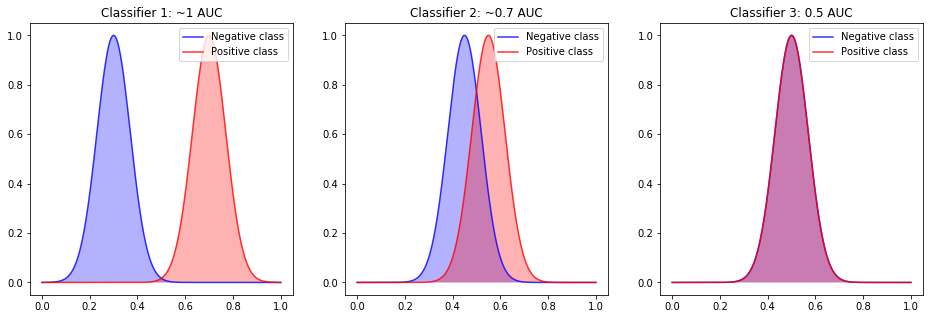

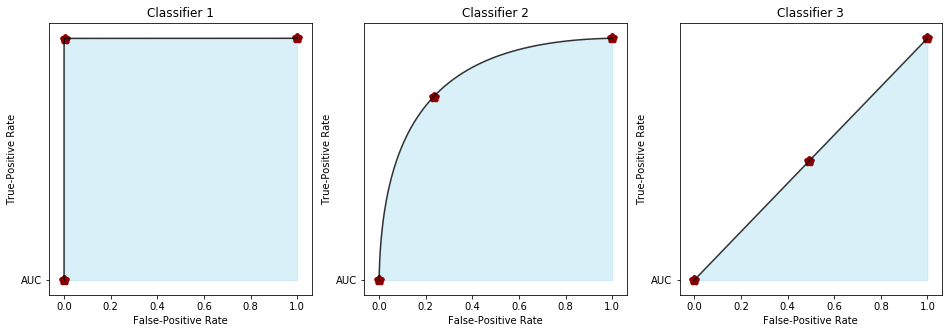

In [6]:
from scipy.stats import norm

# Density of the normal distribution
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

# Distributions plotting setting
fig_dist = plt.figure(figsize=(16, 5))
axes_dist = []
mus = [[0.3, 0.7], [0.45, 0.55], [0.5, 0.5]]
titles = ['~1', '~0.7', '0.5']

# ROC curves-ish setting
fig_roc = fig = plt.figure(figsize=(16, 5))
axes_roc = []

def add_gaussians(ax, mus): 
    x = np.linspace(0, 1, 500)
    neg_dist = gaussian(x, mus[0], 0.07)
    pos_dist = gaussian(x, mus[1], 0.07)
    # Outline
    ax.plot(x, neg_dist, c='b', alpha=0.8, label="Negative class")
    ax.plot(x, pos_dist, c='r', alpha=0.8, label="Positive class")
    # Fill
    ax.fill(x, neg_dist, 'b', x, pos_dist, 'r', alpha=0.3)
    ax.legend(loc="upper right")
def add_roc(ax, mus):
    x = []
    y = []
    for alpha in np.linspace(0, 1, 500):
        x.append(1 - norm.cdf(alpha, loc=mus[0], scale=0.07))
        y.append(1 - norm.cdf(alpha, loc=mus[1], scale=0.07))
    # Outline
    ax.plot(x, y, c='k', alpha=0.8)
    ax.fill_between(x, y, 'AUC', color='skyblue', alpha=0.3)
    x_thres = [x[0], x[int(len(x) / 2)], x[-1]]
    y_thres = [y[0], y[int(len(x) / 2)], y[-1]]
    ax.scatter(x_thres, y_thres, marker='*', color='darkred', linewidths=5)
    plt.xlabel('False-Positive Rate')
    plt.ylabel('True-Positive Rate')

for i in range(3):
    axes_dist.append(fig_dist.add_subplot(131 + i))
    axes_dist[-1].set_title('Classifier ' + str(i + 1) + ': ' + titles[i] + ' AUC')
    add_gaussians(axes_dist[-1], mus[i])
    
    axes_roc.append(fig_roc.add_subplot(131 + i))
    axes_roc[-1].set_title('Classifier ' + str(i + 1))
    add_roc(axes_roc[-1], mus[i])
plt.show()

# Baseline Model

# Deep net example

**Deep learning for image classification**


The starting kit contains a `keras ConvNet` example, using a basic implementation adapted from the [official documentation.](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) 

Some characteristics of the Convolutional Neural Net:

- Set of convolutional layers which apply a convolution operation to the input, passing the result to the next layer. *The convolution emulates the response of an individual neuron to visual stimuli.*
- Set of pooling layers which combine the outputs of neuron clusters at one layer into a single neuron in the next layer. *For example, average pooling compute the average value from each of a cluster of neurons at the prior layer.*
- Flatten and fully connected layers, used to convert the 3D feature maps computed with the previous layers to 1D feature vector and make binary classification.

The general architecture for the classification task is given below : 

<img src="./img/convnet_archi.jpg" />
<div style="text-align: center; font-style: italic">Convolutional Network Architecture</div>
<br />

First load the data, then the data has to be rescaled in the range $[0,1]$: 

In [2]:
from problem import get_train_data, get_test_data

X_train_origin, y_train = get_train_data()
X_test_origin, y_test = get_test_data()

In [3]:
print("Shape of training set : {}".format(X_train_origin.shape))

Shape of training set : (619, 160000)


In [4]:
X_train_origin /= 255
X_test_origin /= 255

By default, the dataset is a pandas Dataframe. For convenience, we'll convert it into a numpy array.

In [5]:
type(X_train_origin)

pandas.core.frame.DataFrame

In [6]:
X_train_origin = X_train_origin.values
X_test_origin = X_test_origin.values

type(X_train_origin)

numpy.ndarray

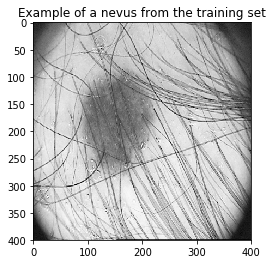

In [7]:
X_train_origin = X_train_origin.reshape(-1, 400, 400)
X_test_origin = X_test_origin.reshape(-1, 400, 400)

plt.imshow(X_train_origin[0], cmap='Greys_r')
plt.title("Example of a nevus from the training set")
plt.show()

We can see that there is a circular shadow around the nevus area and that most of the nevus are in the middle of the image, as an extra preprocessing step, we can crop the image :

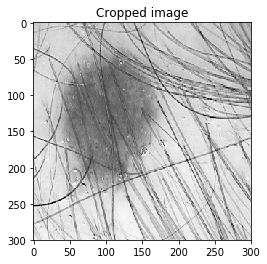

In [8]:
def crop_center(img, cropx, cropy):
    y, x = img.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)    
    return img[starty:starty + cropy, startx:startx + cropx]

plt.imshow(crop_center(X_train_origin[0], 300, 300), cmap='Greys_r')
plt.title("Cropped image")
plt.show()

In [9]:
X_train_origin = np.array([crop_center(image, 300, 300) for image in X_train_origin])
X_test_origin = np.array([crop_center(image, 300, 300) for image in X_test_origin])

In [10]:
X_train_origin.shape

(619, 300, 300)

One specificity of this ConvNet implementation is that the images have to be reshaped to include the channel :

In [11]:
X_train_origin = X_train_origin.reshape(-1, 300, 300, 1)
X_test_origin = X_test_origin.reshape(-1, 300, 300, 1)

In [12]:
print("Shape of training set : {}".format(X_train_origin.shape))

Shape of training set : (619, 300, 300, 1)


In order to fasten the computation, we can downscale the images : 

In [13]:
from skimage.transform import resize

X_train = np.array([resize(image, (128, 128, 1), mode='reflect', anti_aliasing=True) for image in X_train_origin])
X_test = np.array([resize(image, (128, 128, 1), mode='reflect', anti_aliasing=True) for image in X_test_origin])

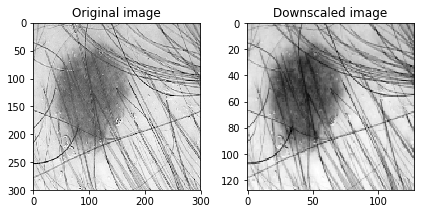

In [14]:
plt.subplot(121)
plt.imshow(X_train_origin[0].reshape(300, 300), cmap='Greys_r')
plt.title("Original image")


plt.subplot(122)
plt.imshow(X_train[0].reshape(128, 128), cmap='Greys_r')
plt.title("Downscaled image")
plt.tight_layout()
plt.show()

Our model follows the architecture described above, it contains 3 convolutionnal layers with relu activation and their associated max pooling layers, the classification task will be performed by a fully connected layer with hyperbolic tangent activation and an output layer with sigmoid activation (because we're in the case of binary classification). A dropout layer is also implemented to prevent overfitting in the training phase (by randomly *killing* a fraction rate of input units at each update).

An overall summary of our model is given here :

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, MaxPooling2D, Conv2D, Flatten

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(128, 128, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('tanh'))
model.add(Dropout(0.6))
model.add(Dense(1))
model.add(Activation('sigmoid'))


print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
activation_16 (Activation)   (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 61, 61, 32)        9248      
_________________________________________________________________
activation_17 (Activation)   (None, 61, 61, 32)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 64)        18496     
__________

Let's run our model and see how it does on our dataset : 

In [27]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 25
batch_size = 32

model.fit(X_train, y_train, 
           batch_size=batch_size, 
           epochs=epochs, 
           verbose=1)

Epoch 1/25
619/619 [==============================] - 8s 13ms/step - loss: 0.7043 - acc: 0.4943
Epoch 2/25
619/619 [==============================] - 8s 13ms/step - loss: 0.6889 - acc: 0.5073
Epoch 3/25
619/619 [==============================] - 8s 13ms/step - loss: 0.6695 - acc: 0.5864
Epoch 4/25
619/619 [==============================] - 8s 13ms/step - loss: 0.6393 - acc: 0.6333
Epoch 5/25
619/619 [==============================] - 8s 12ms/step - loss: 0.6645 - acc: 0.6123
Epoch 6/25
619/619 [==============================] - 8s 13ms/step - loss: 0.6528 - acc: 0.6107
Epoch 7/25
619/619 [==============================] - 8s 13ms/step - loss: 0.6379 - acc: 0.6349
Epoch 8/25
619/619 [==============================] - 8s 12ms/step - loss: 0.6409 - acc: 0.6204
Epoch 9/25
619/619 [==============================] - 8s 12ms/step - loss: 0.6422 - acc: 0.6171
Epoch 10/25
619/619 [==============================] - 8s 13ms/step - loss: 0.6123 - acc: 0.6559
Epoch 11/25
619/619 [==================

After 25 epochs, our model has reached 79% of accuracy in the training phase. Let's see how it performs on test data : 

In [28]:
y_pred = model.predict_classes(X_test)

In [75]:
y_pred_probas = model.predict_proba(X_test)

In [29]:
from sklearn.metrics import classification_report

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.74      0.76      0.75        68
           1       0.68      0.65      0.67        52

   micro avg       0.72      0.72      0.72       120
   macro avg       0.71      0.71      0.71       120
weighted avg       0.72      0.72      0.72       120



### Conclusion and tips :

Our model seems to not overfit thank's to the aggressive Dropout strategy, it seems also to have a good precision on detecting abnormal moles but there is still plenty of room left for improvement!

In deep learning, the amount of data is crucial, one idea of improvement would be to use data augmentation techniques. Another idea would be to let the model runs for many more epochs or to improve the architecture of the model. Also, the downscale strategy might be too aggressive. 

# Local testing

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Note that the test runs on your files in [`submissions/starting_kit`](/tree/submissions/starting_kit), not on the classes defined in the cells of this notebook.

Check list

- Make sure you have installed `ramp-workflow` locally (see [above](#Installation-of-ramp-workflow))
- Make sure that the python files `object_detector.py` is in the  `submissions/your_submission` folder, and the train and test data are in [`data`](/tree/data)
- If you haven't yet, download the images by executing 
  ```
  python download_data.py
  ```

Finally, make sure the local processing goes through by running the

```
ramp_test_submission --submission your_submission
```

If you want to quickly test the that there are no obvious code errors, use the `--quick-test` keyword to only use data from the first 30 images. 

```
ramp_test_submission --submission your_submission --quick-test
```

In [91]:
!ramp_test_submission --quick-test

Testing Melanomas detection
Reading train and test files from ./data ...
Reading cv ...
Training submissions\starting_kit ...
CV fold 0
	score  mixed  spe@97   auc   rec   spe   acc
	train   0.38    0.00  1.00  1.00  1.00  1.00
	valid   0.58    0.00  0.67  0.67  0.67  0.67
	test    0.59    0.13  0.59  0.53  0.60  0.57
CV fold 1
	score  mixed  spe@97   auc   rec   spe   acc
	train   0.38     0.0  1.00  1.00  1.00  1.00
	valid   0.47     0.0  0.89  0.67  1.00  0.83
	test    0.63     0.0  0.64  0.60  0.53  0.57
CV fold 2
	score  mixed  spe@97   auc   rec   spe   acc
	train   0.38     0.0  1.00  1.00  1.00  1.00
	valid   0.50     0.0  1.00  1.00  0.33  0.67
	test    0.62     0.0  0.66  0.67  0.47  0.57
CV fold 3
	score  mixed  spe@97   auc   rec   spe   acc
	train   0.38    0.00  1.00  1.00  1.00  1.00
	valid   0.72    0.00  0.39  0.33  0.67  0.50
	test    0.50    0.13  0.70  0.67  0.80  0.73
CV fold 4
	score  mixed  spe@97   auc   rec   spe   acc
	train   0.38     0.0  1.00  1.00  1.00  1

In [83]:
!ramp_test_submission --quick-test --submission ConvNet

Testing Melanomas detection
Reading train and test files from ./data ...
Reading cv ...
Training submissions\ConvNet ...
CV fold 0
	score  mixed  spe@97   auc   rec   spe   acc
	train   0.80    0.25  0.12  0.08  0.33  0.21
	valid   0.66    0.67  0.11  0.00  0.33  0.17
	test    0.68    0.40  0.23  0.20  0.40  0.30
CV fold 1
	score  mixed  spe@97   auc  rec  spe  acc
	train   0.71     0.0  0.41  0.0  1.0  0.5
	valid   0.62     0.0  0.78  0.0  1.0  0.5
	test    0.64     0.0  0.70  0.0  1.0  0.5
CV fold 2
	score  mixed  spe@97   auc  rec  spe  acc
	train   0.69    0.00  0.50  1.0  0.0  0.5
	valid   0.60    0.33  0.33  1.0  0.0  0.5
	test    0.68    0.00  0.53  1.0  0.0  0.5
CV fold 3
	score  mixed  spe@97  auc  rec  spe  acc
	train   0.69     0.0  0.5  0.0  1.0  0.5
	valid   0.69     0.0  0.5  0.0  1.0  0.5
	test    0.69     0.0  0.5  0.0  1.0  0.5
CV fold 4
	score  mixed  spe@97  auc  rec  spe  acc
	train   0.69     0.0  0.5  0.0  1.0  0.5
	valid   0.69     0.0  0.5  0.0  1.0  0.5
	test  

2019-01-31 17:30:11.552470: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX AVX2
Using TensorFlow backend.


If you get to see the train and test scores, and no errors, then you can submit your model to the ramp.studio.

# Submitting to [ramp.studio](http://ramp.studio)

Once you found a good model, you can submit them to [ramp.studio](https://www.ramp.studio). First, if it is your first time using RAMP, [sign up](https://www.ramp.studio/sign_up), otherwise [log in](https://www.ramp.studio/login). Then find the event for this RAMP. Sign up for the event. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your sandbox and copy-paste (or upload) [`feature_extractor.py`](/edit/submissions/starting_kit/feature_extractor.py). Save it, rename it, then submit it. The submission is trained and tested on our backend in the same way as `ramp_test_submission` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in my *submissions*. Once it is trained, you get a mail, and your submission shows up on the *public leaderboard*. 
If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in *my submission*. You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., _locally_, and checking them with `ramp_test_submission`. The script prints scores for each cross-validation fold
```
CV fold X
	score  mixed  spe@97   auc  rec  spe  acc
	train   0.71     0.0  0.41  0.0  1.0  0.5
	valid   0.62     0.0  0.78  0.0  1.0  0.5
	test    0.64     0.0  0.70  0.0  1.0  0.5
```

and the mean cross-validation score at the end 

```
Mean CV scores
----------------------------
	score         mixed       spe@97      ...                spe           acc
	step                                  ...                                 
	train  0.71 ± 0.042   0.05 ± 0.1      ...       0.67 ± 0.422  0.44 ± 0.117
	valid  0.65 ± 0.035  0.2 ± 0.267      ...       0.67 ± 0.422  0.43 ± 0.133
	test   0.67 ± 0.018  0.08 ± 0.16      ...       0.68 ± 0.412   0.46 ± 0.08
----------------------------
```


# More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).